# TASK 1

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import scipy.stats as stats

import stan_utility
import pystan
import matplotlib as mpl

In [2]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
light_grey="#DDDDDD"

colors=[light, light_highlight, mid, mid_highlight,
        dark, dark_highlight, light_grey]

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

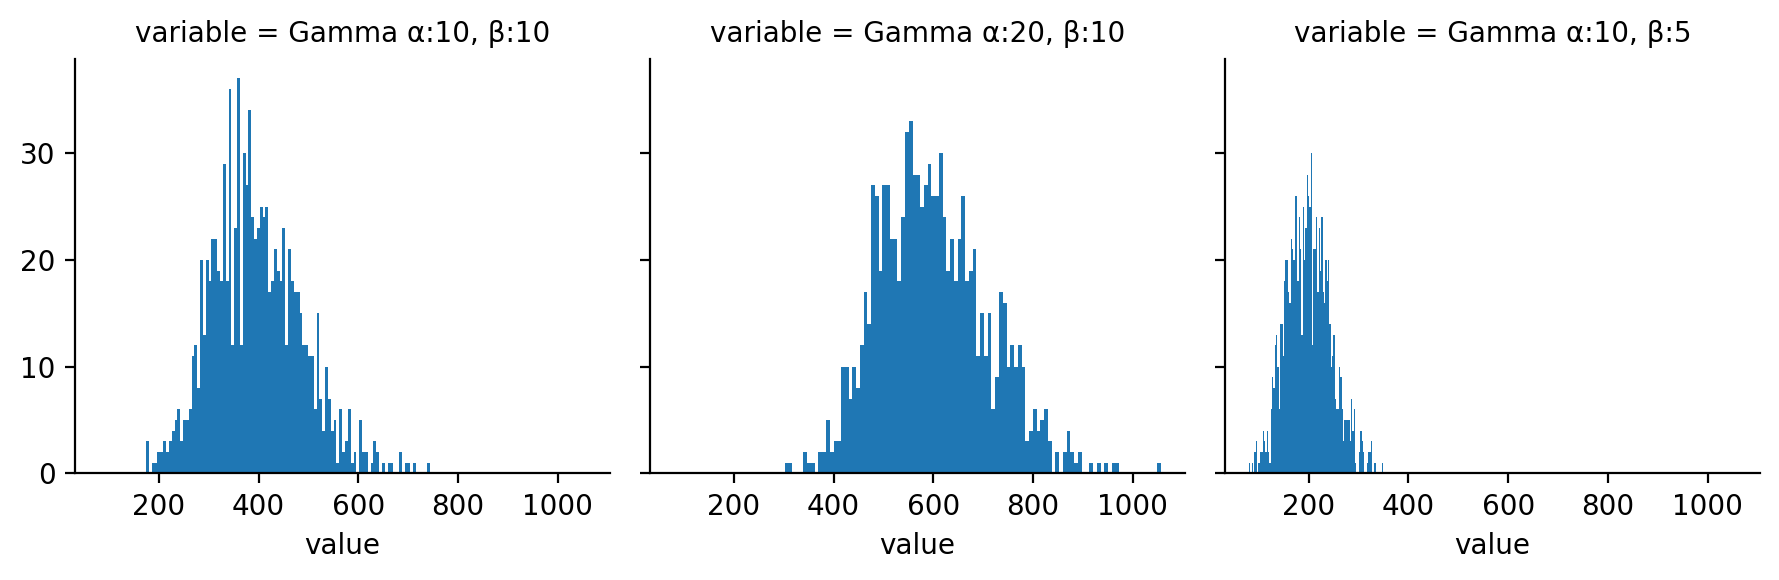

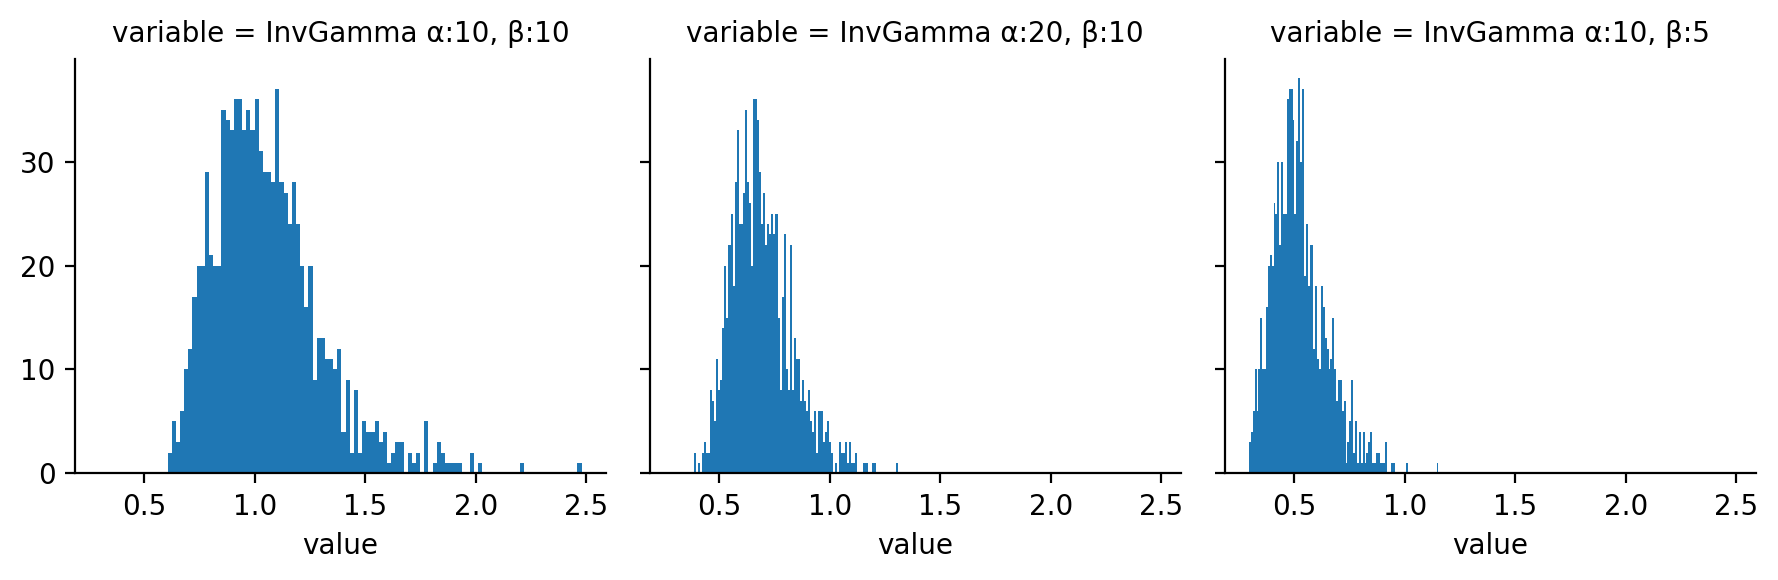

In [3]:
size = 1000
gamma_dict = {
    "Gamma α:10, β:10": np.random.gamma(20, 20, size),
    "Gamma α:20, β:10": np.random.gamma(30, 20, size),
    "Gamma α:10, β:5": np.random.gamma(20, 10, size)
}

invgamma_dict = {
    "InvGamma α:10, β:10": stats.invgamma.rvs(a=20, scale=20, size=size),
    "InvGamma α:20, β:10": stats.invgamma.rvs(a=30, scale=20, size=size),
    "InvGamma α:10, β:5": stats.invgamma.rvs(a=20, scale=10, size=size)
}

gamma_df = pd.DataFrame.from_dict(gamma_dict)
gamma_melted = gamma_df.melt()

invgamma_df = pd.DataFrame.from_dict(invgamma_dict)
invgamma_melted = invgamma_df.melt()

Graph = sns.FacetGrid(gamma_melted, col="variable", sharex=True)
Graph.map(plt.hist, "value", cumulative=False, bins=100)

Graph = sns.FacetGrid(invgamma_melted, col="variable", sharex=True)
Graph.map(plt.hist, "value", cumulative=False, bins=100)

The larger alpha for a fixed beta, the more the probability density function will move to the right. 
The larger beta for a fixed alpha, the more it will move to zero.

In [4]:
with open('prior_gamma.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng(alpha, beta);
    real inv_gamma = inv_gamma_rng(alpha, beta);
}


In [5]:
gamma_model = stan_utility.compile_model('prior_gamma.stan')

Using cached StanModel


In [6]:
sim_md = gamma_model.sampling(data={'alpha': 7, 'beta': 2},
                              seed=56862385,
                              algorithm="Fixed_param",
                              iter=1000, 
                              warmup=0,
                              chains=1)

In [7]:
params=sim_md.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

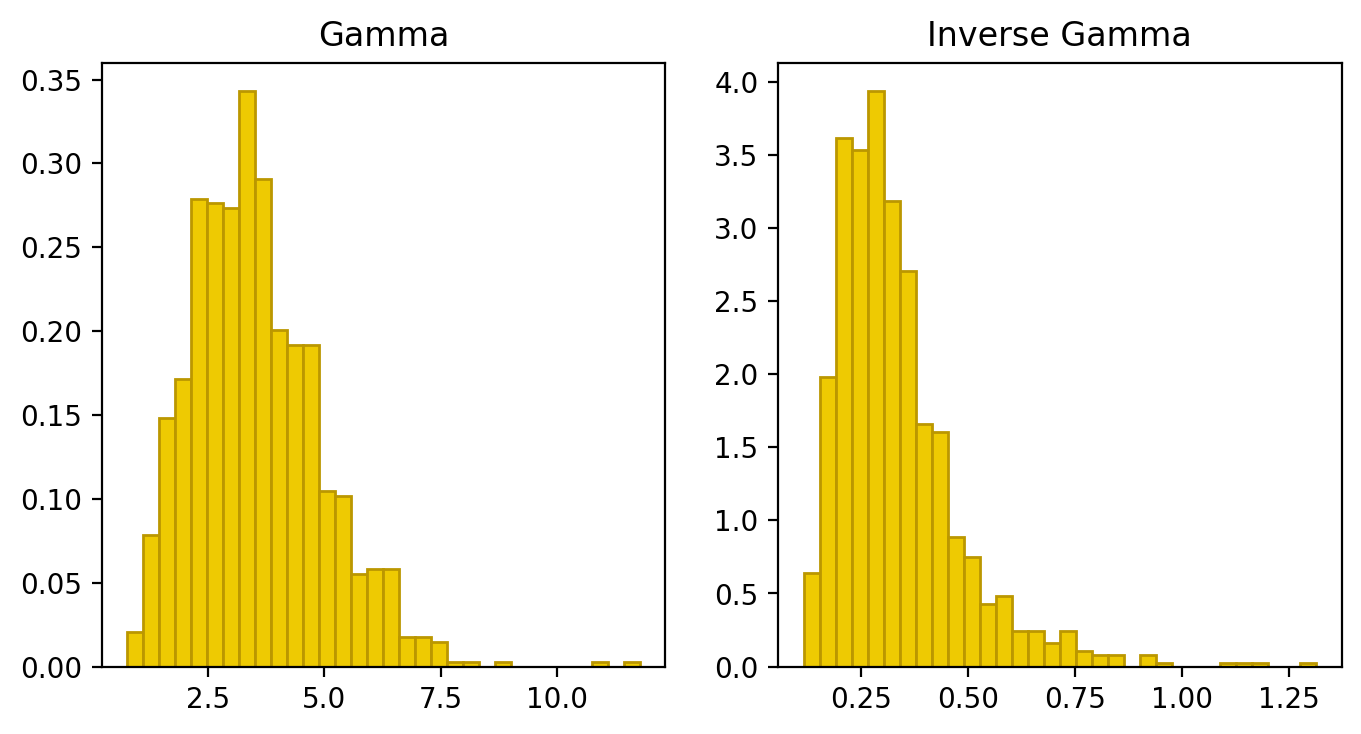

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)

ax2=axes[1]
ax2.hist(inv_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)

ax1.set_title('Gamma')
ax2.set_title('Inverse Gamma')
plt.show()


In [9]:
with open('gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector gamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - gamma_cdf(theta[2], exp(y[1]), exp(y[2]));
        
        return gammas;
    }
}

data {
    real lower_bound;
    real upper_bound;
    real alpha_guess;
    real beta_guess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lower_bound, upper_bound]';
    
    vector[2] y_guess = [log(alpha_guess), log(beta_guess)]';
    y = algebra_solver(gamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [10]:
gamma_tuning=stan_utility.compile_model('gamma_tune.stan')

Using cached StanModel


In [11]:
data = dict(lower_bound =5 , upper_bound=10, alpha_guess=7, beta_guess=2)  
tuned = gamma_tuning.sampling(data=data,
                                seed=56862385,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [12]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 46.0	beta: 6.0


In [13]:
sim_gamma = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=56862385)

In [14]:
params=sim_gamma.extract()
par_gamma=params['gamma']

In [15]:
with open('inv_gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector gamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2]));

        return gammas;
    }
}

data {
    real lower_bound;
    real upper_bound;
    real alpha_guess;
    real beta_guess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lower_bound, upper_bound]';

    vector[2] y_guess = [log(alpha_guess), log(beta_guess)]';
    y = algebra_solver(gamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [16]:
inv_gamma_tuning=stan_utility.compile_model('inv_gamma_tune.stan')

Using cached StanModel


In [17]:
data = dict(lower_bound =5 , upper_bound=10, alpha_guess=2, beta_guess=5)
inv_tuned = inv_gamma_tuning.sampling(data=data,
                                seed=56862385,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [18]:
alpha = np.round(inv_tuned.extract()['alpha'][0])
beta = np.round(inv_tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 46.0	beta: 314.0


In [19]:
sim_gamma_inv = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=56862385)

In [20]:
inv_params=sim_gamma_inv.extract()
par_inv_gamma=inv_params['inv_gamma']

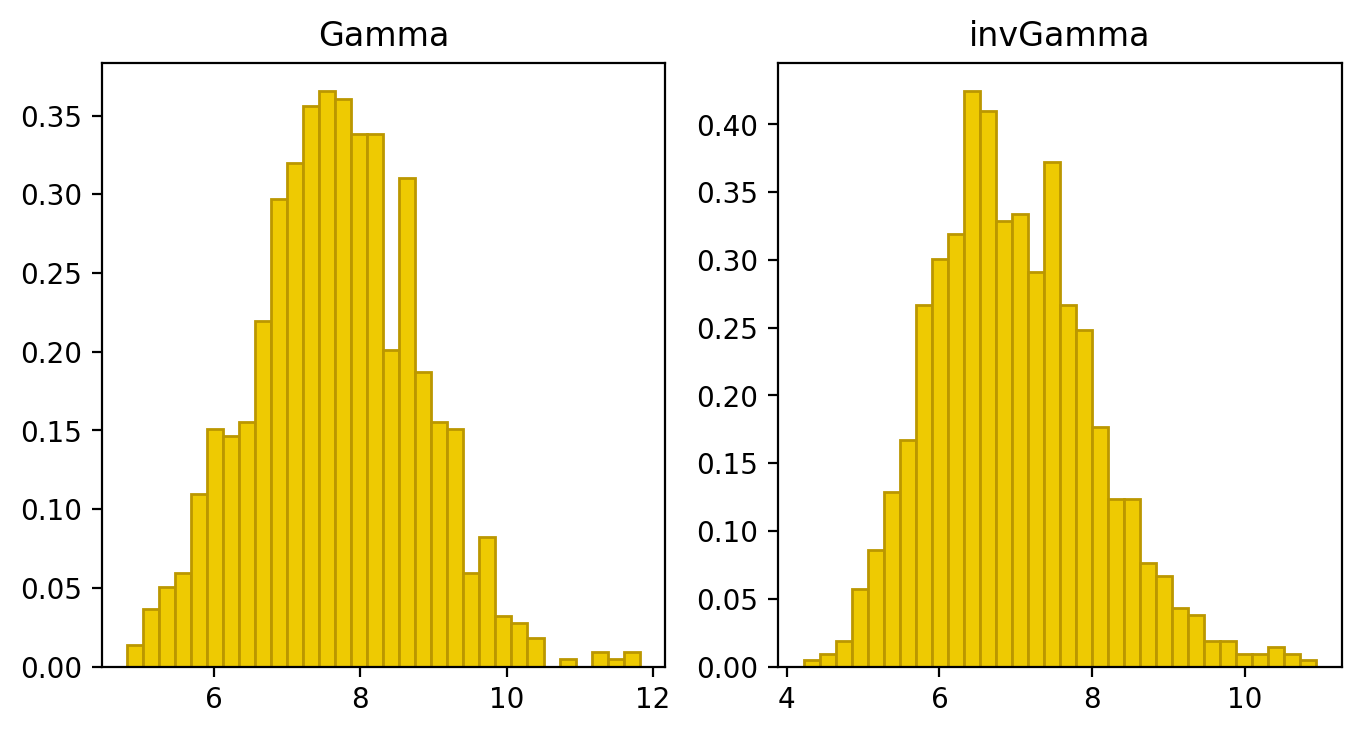

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(par_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)

ax2=axes[1]
ax2.hist(par_inv_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)

ax1.set_title('Gamma')
ax2.set_title('invGamma')
plt.show()

# TASK 2

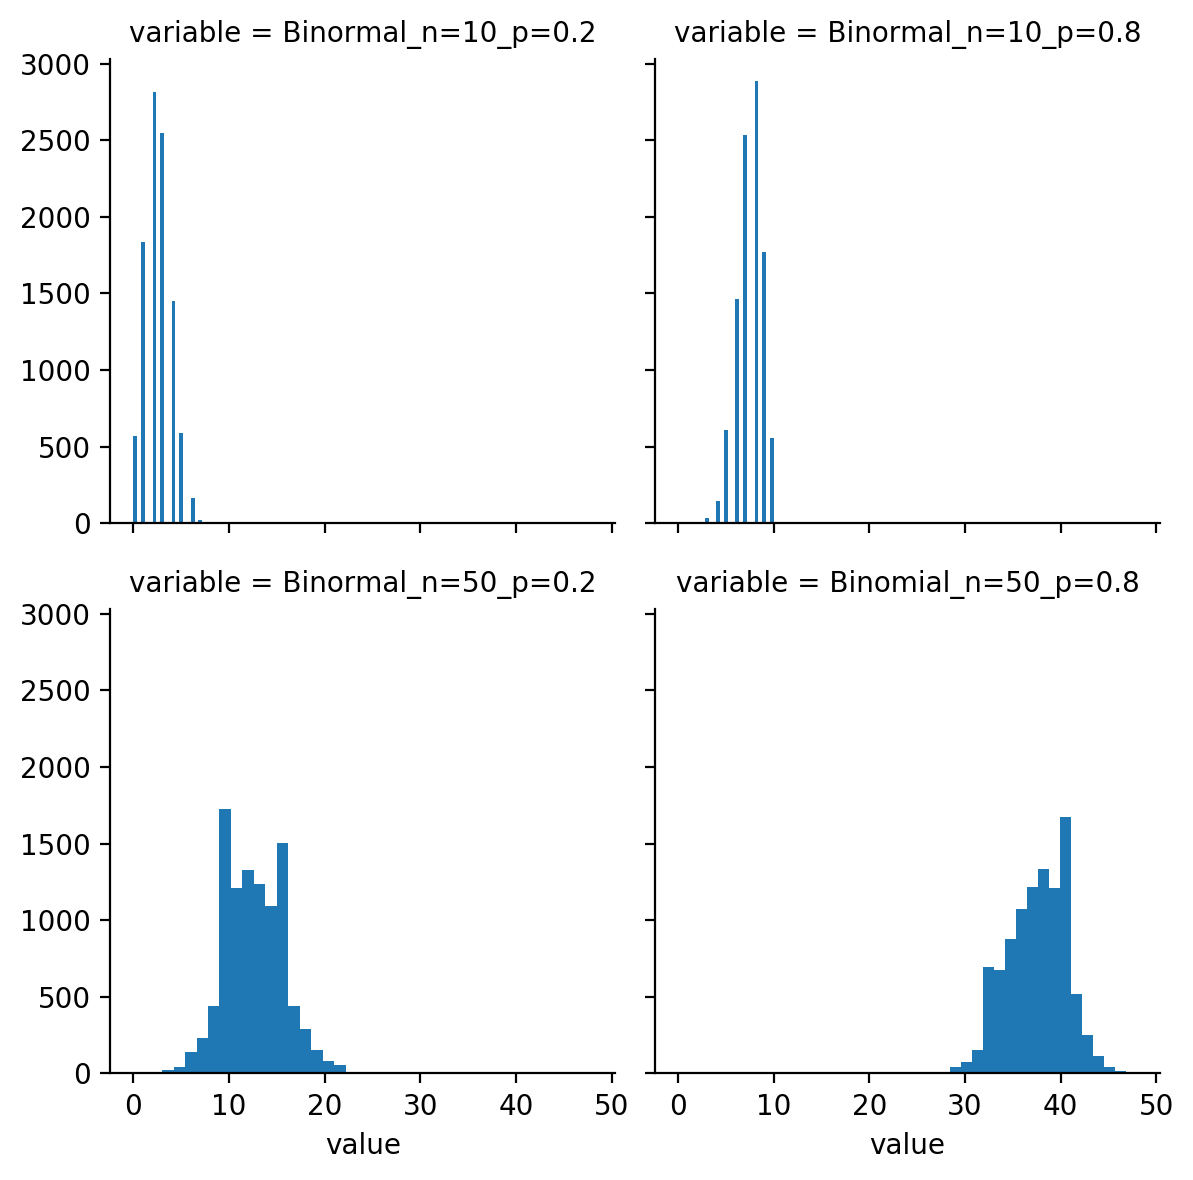

In [22]:
size = 10000
binormal_dict = {
    "Binormal_n=10_p=0.2": np.random.binomial(10, 0.25, size),
    "Binormal_n=10_p=0.8": np.random.binomial(10, 0.75, size),
    "Binormal_n=50_p=0.2": np.random.binomial(50, 0.25, size),
    "Binomial_n=50_p=0.8": np.random.binomial(50, 0.75, size)
}

binormal_df = pd.DataFrame.from_dict(binormal_dict)
melted_binormal = binormal_df.melt()

Graph = sns.FacetGrid(melted_binormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

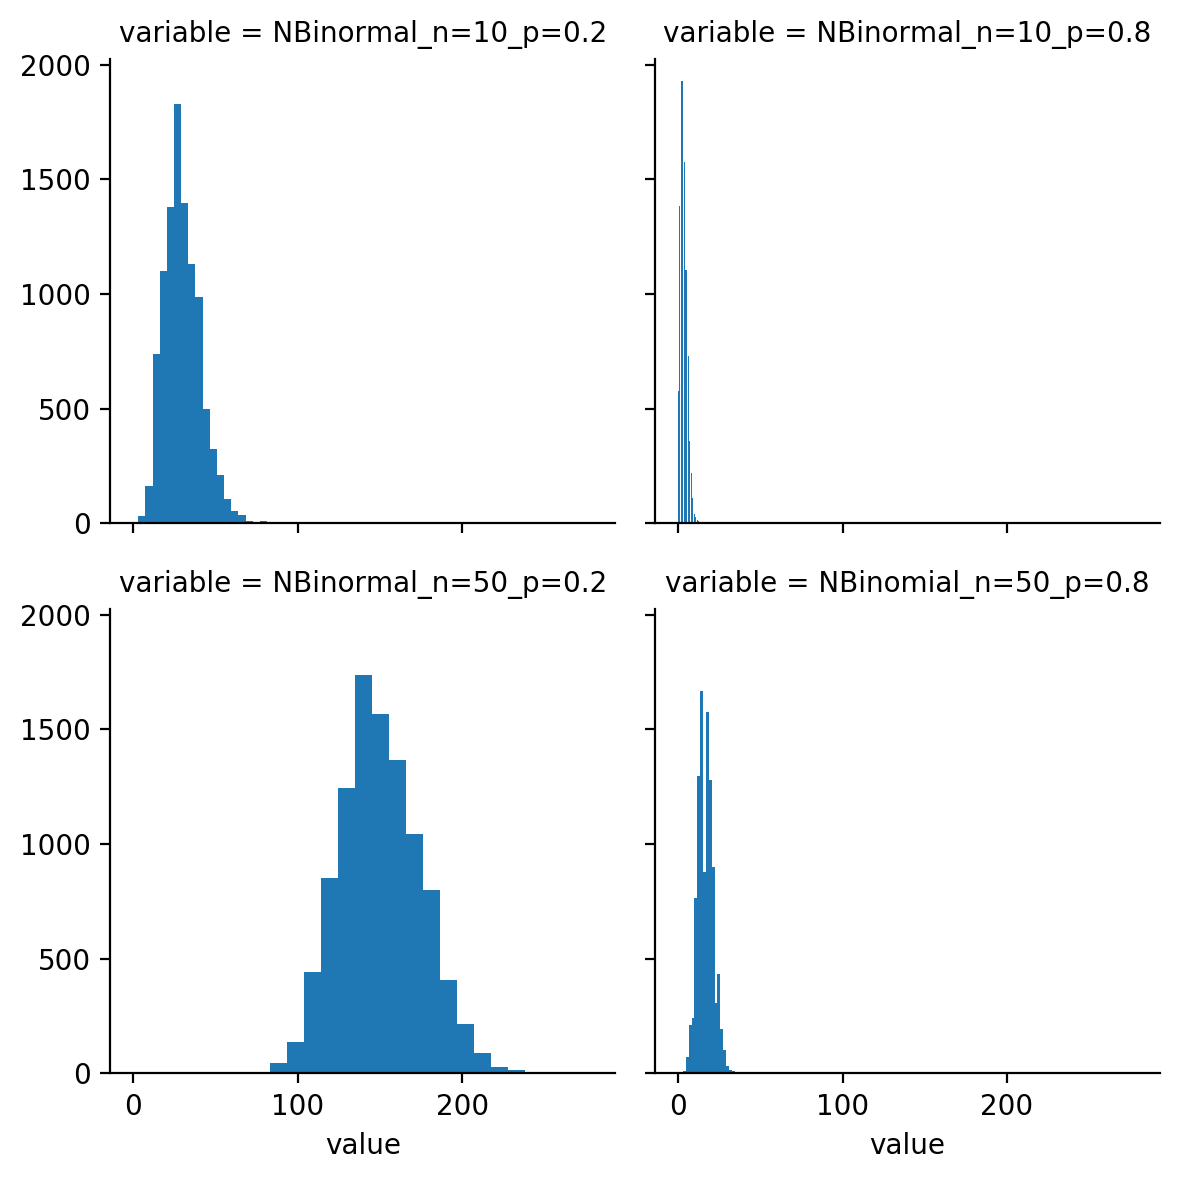

In [23]:
Nbinormal_dict = {
    "NBinormal_n=10_p=0.2": np.random.negative_binomial(10, 0.25, size),
    "NBinormal_n=10_p=0.8": np.random.negative_binomial(10, 0.75, size),
    "NBinormal_n=50_p=0.2": np.random.negative_binomial(50, 0.25, size),
    "NBinomial_n=50_p=0.8": np.random.negative_binomial(50, 0.75, size)
}

Nbinormal_df = pd.DataFrame.from_dict(Nbinormal_dict)
melted_Nbinormal = Nbinormal_df.melt()

Graph = sns.FacetGrid(melted_Nbinormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

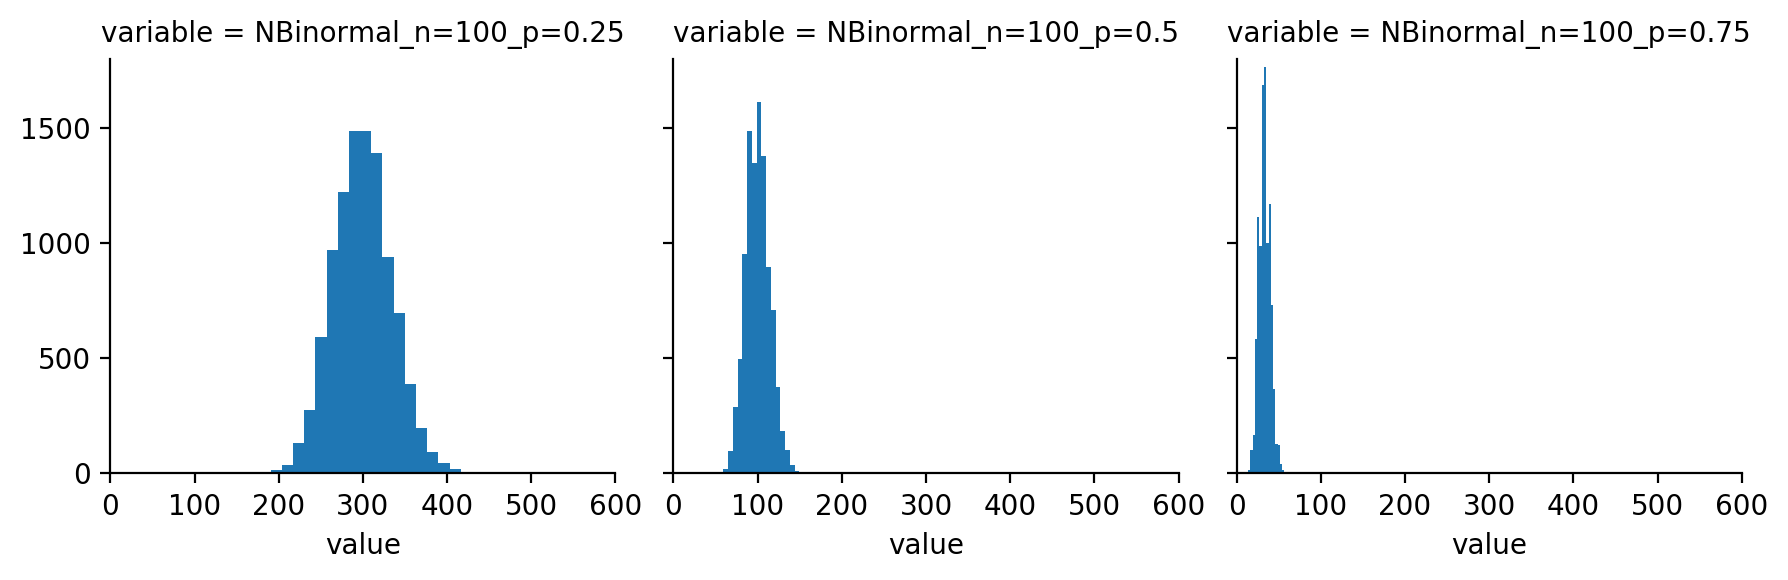

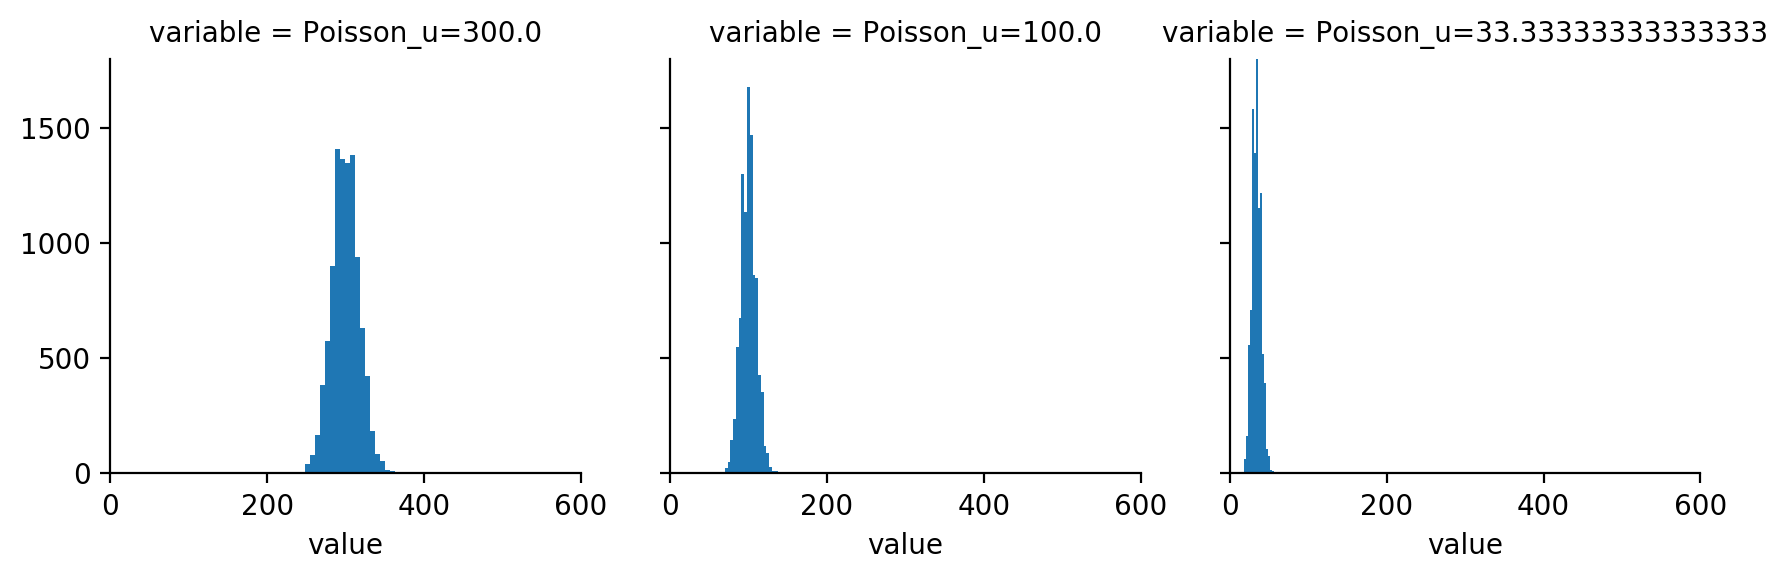

In [24]:
p=[0.25,0.5,0.75]
n=100
u=[stats.nbinom.mean(n, x) for x in p]

Nbinormal_dict_comp = {
    "NBinormal_n=100_p={}".format(p[0]): np.random.negative_binomial(n, p[0], size),
    "NBinormal_n=100_p={}".format(p[1]): np.random.negative_binomial(n, p[1], size),
    "NBinormal_n=100_p={}".format(p[2]): np.random.negative_binomial(n, p[2], size),
}

Poisson_dict_comp = {
    "Poisson_u={}".format(u[0]): np.random.poisson(u[0], size=size),
    "Poisson_u={}".format(u[1]): np.random.poisson(u[1], size=size),
    "Poisson_u={}".format(u[2]): np.random.poisson(u[2], size=size),
}


Nbinormal_df_comp = pd.DataFrame.from_dict(Nbinormal_dict_comp)
melted_Nbinormal_comp = Nbinormal_df_comp.melt()

Graph = sns.FacetGrid(melted_Nbinormal_comp, col="variable", sharex=True, col_wrap=3)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

Poisson_df_comp = pd.DataFrame.from_dict(Poisson_dict_comp)
melted_Poisson_comp = Poisson_df_comp.melt()

Graph = sns.FacetGrid(melted_Poisson_comp, col="variable", sharex=True, col_wrap=3)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

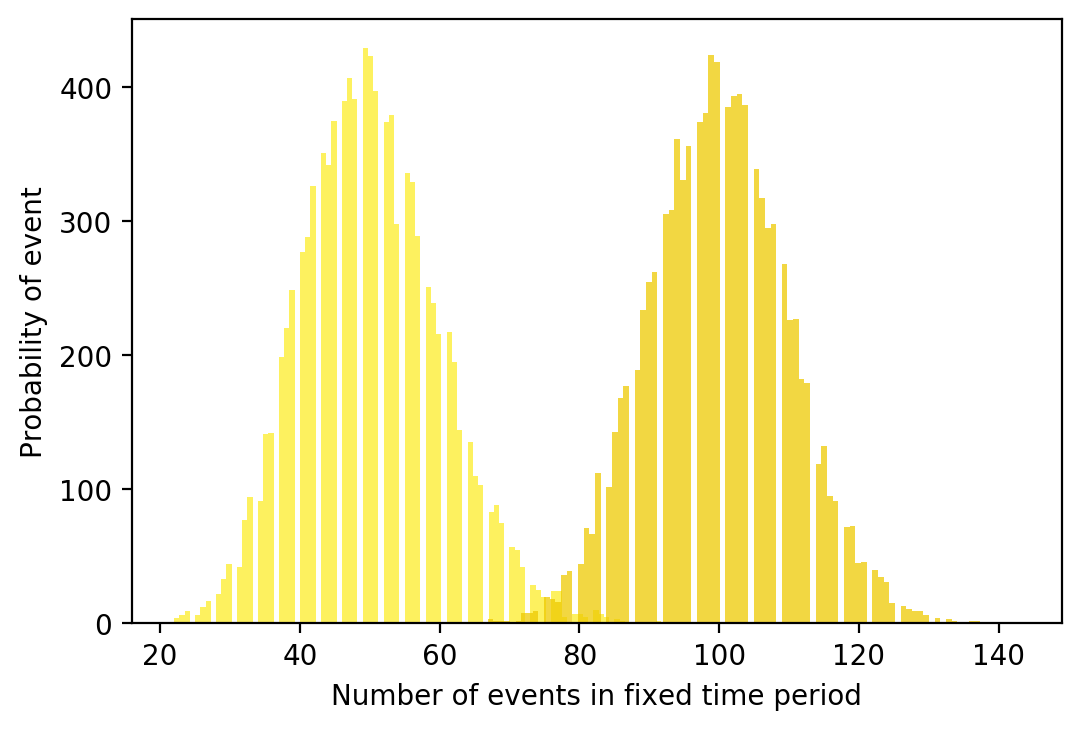

In [25]:
# Probability of success - p
p = 0.5
# Number of succeses - n
n = 50
# Mean = n/p
u = n/p

plt.hist(np.random.negative_binomial(n, p, size), bins=100, color=mid, alpha=0.75)
plt.hist(np.random.poisson(u, size), bins=100, color=dark, alpha=0.75)
plt.xlabel("Number of events in fixed time period")
plt.ylabel("Probability of event")
plt.show()

# TASK 3

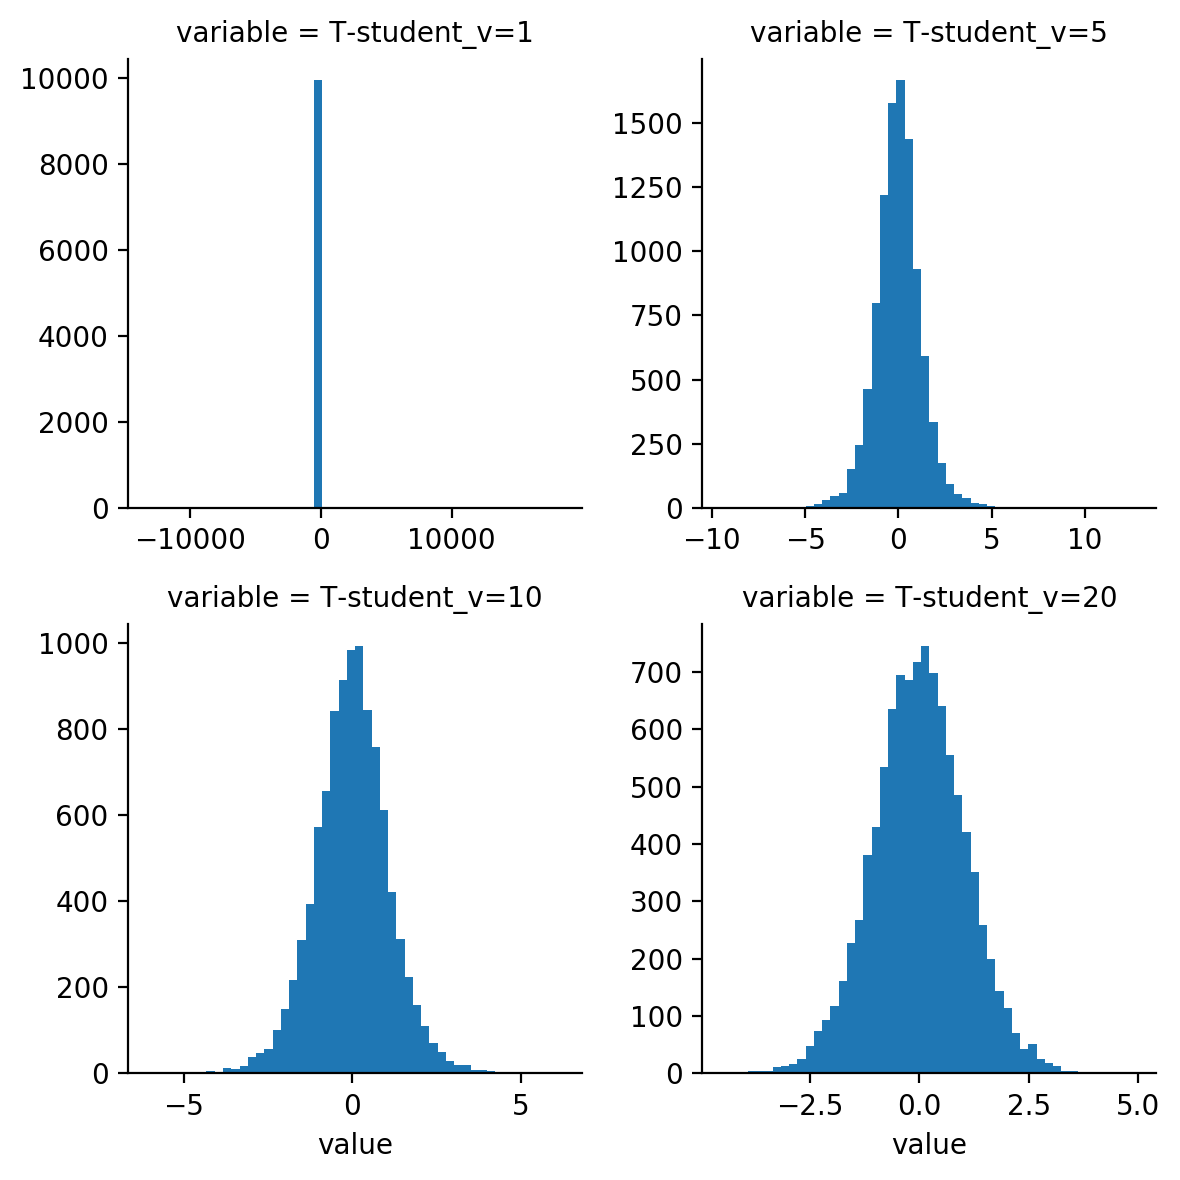

In [26]:
size = 10000
n=[1,5,10,20]
student_dict: dict = {}

for param in n:
    student_dict['T-student_v={}'.format(param)] = np.random.standard_t(param, size)


tstudent_df = pd.DataFrame.from_dict(student_dict)
melted_tstudent = tstudent_df.melt()

Graph = sns.FacetGrid(melted_tstudent, col="variable", sharey=False, sharex=False, col_wrap=2)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=50)

Cauchy distribution

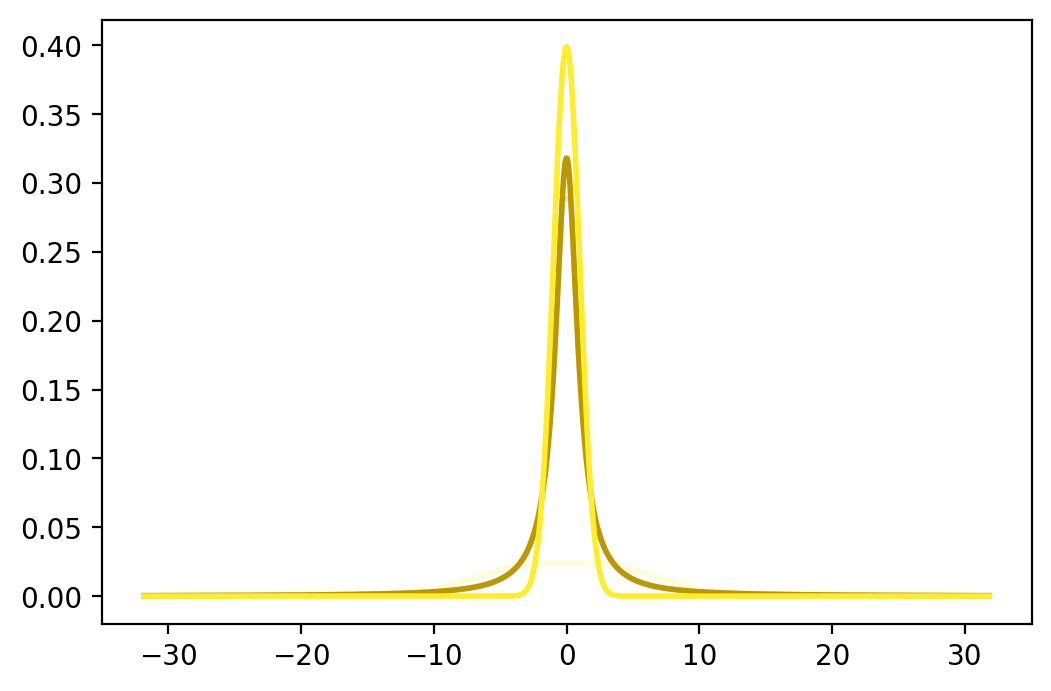

In [27]:
samples = [10, 100, 1000]
fig, ax = plt.subplots(1, 1)
for i in range(len(samples)):
    xc = np.linspace(stats.t.ppf(0.01, n[0]),
                    stats.t.ppf(0.99, n[0]),samples[i])
    ax.plot(xc, stats.t.pdf(xc, n[0]),color=colors[-i],linewidth=2)

ax.plot(xc, stats.norm.pdf(xc),color=colors[2],linewidth=2)
plt.show()


In [28]:
student_t_model = stan_utility.compile_model('student_t.stan')

Using cached StanModel


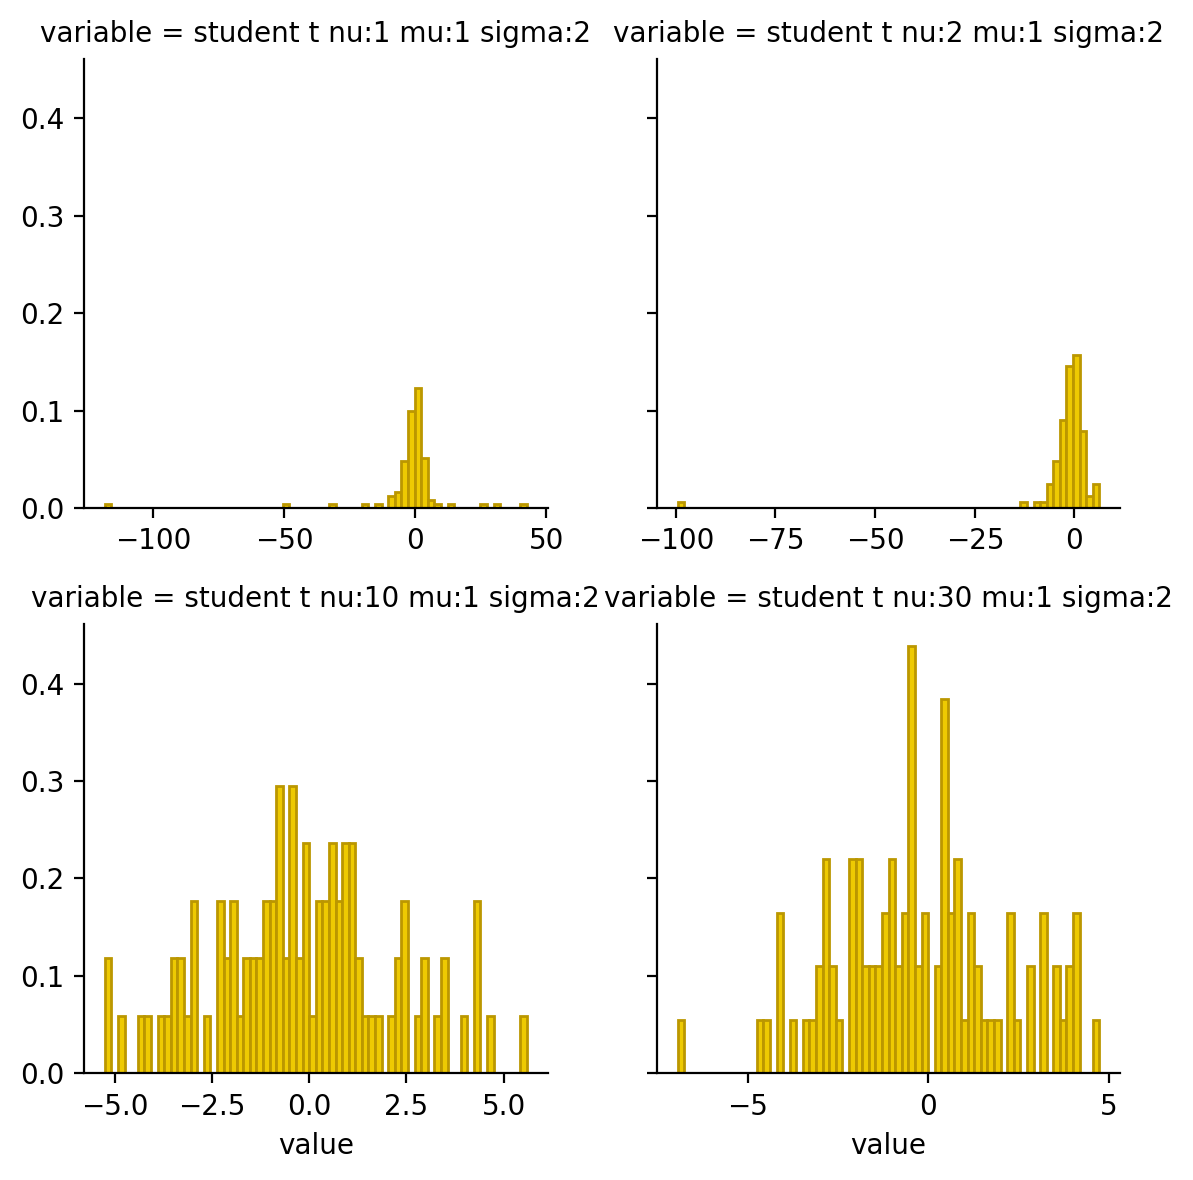

In [29]:
freedom_degrees = [1, 2, 10, 30]
student_dict: dict = {}

for fd in freedom_degrees:
        sim_student=student_t_model.sampling(data={'nu':fd, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param",
                      iter=100,
                      warmup=0,
                      chains=1,
                      seed=56862385)
        params_student=sim_student.extract()
        student=params_student['y']
        student_dict['student t nu:{} mu:1 sigma:2'.format(fd)] = student

student_df = pd.DataFrame.from_dict(student_dict)
melted_student = student_df.melt()

graph = sns.FacetGrid(melted_student, col="variable", sharey=True, sharex=False, col_wrap=2)
graph.map(plt.hist, "value", cumulative=False, bins=64, color=dark,edgecolor=dark_highlight,density=True)

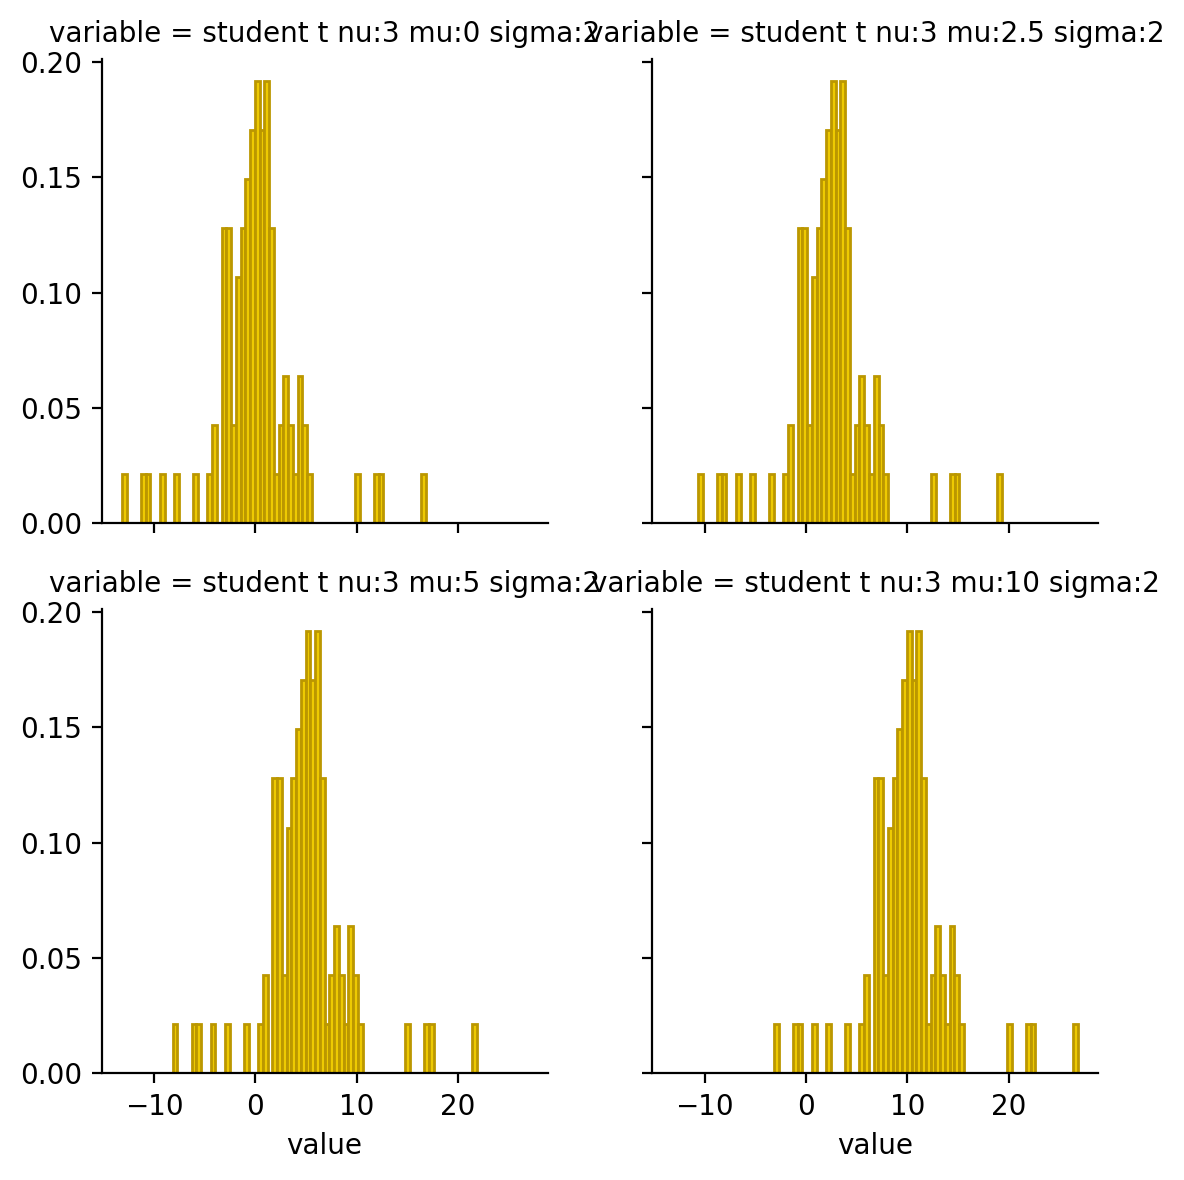

In [30]:
variance = [0, 2.5, 5, 10]
student_dict: dict = {}

for var in variance:
        sim_student=student_t_model.sampling(data={'nu':3, 'mu':var, 'sigma':2},
                      algorithm="Fixed_param",
                      iter=100,
                      warmup=0,
                      chains=1,
                      seed=56862385)
        params_student=sim_student.extract()
        student=params_student['y']
        student_dict['student t nu:3 mu:{} sigma:2'.format(var)] = student

student_df = pd.DataFrame.from_dict(student_dict)
melted_student = student_df.melt()

Graph = sns.FacetGrid(melted_student, col="variable", sharey=True, sharex=True, col_wrap=2)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=64, color=dark,edgecolor=dark_highlight,density=True)

In [31]:
sim_cauchy_250=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=250,
                      warmup=0,
                      chains=1,
                      seed=56862385)
sim_cauchy_500=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=500,
                      warmup=0,
                      chains=1,
                      seed=56862385)
sim_cauchy_750=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=750,
                      warmup=0,
                      chains=1,
                      seed=56862385)
sim_cauchy_1000=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=1000,
                      warmup=0,
                      chains=1,
                      seed=56862385)

cauchy_250=sim_cauchy_250.extract()['y']
cauchy_500=sim_cauchy_500.extract()['y']
cauchy_750=sim_cauchy_750.extract()['y']
cauchy_1000=sim_cauchy_1000.extract()['y']

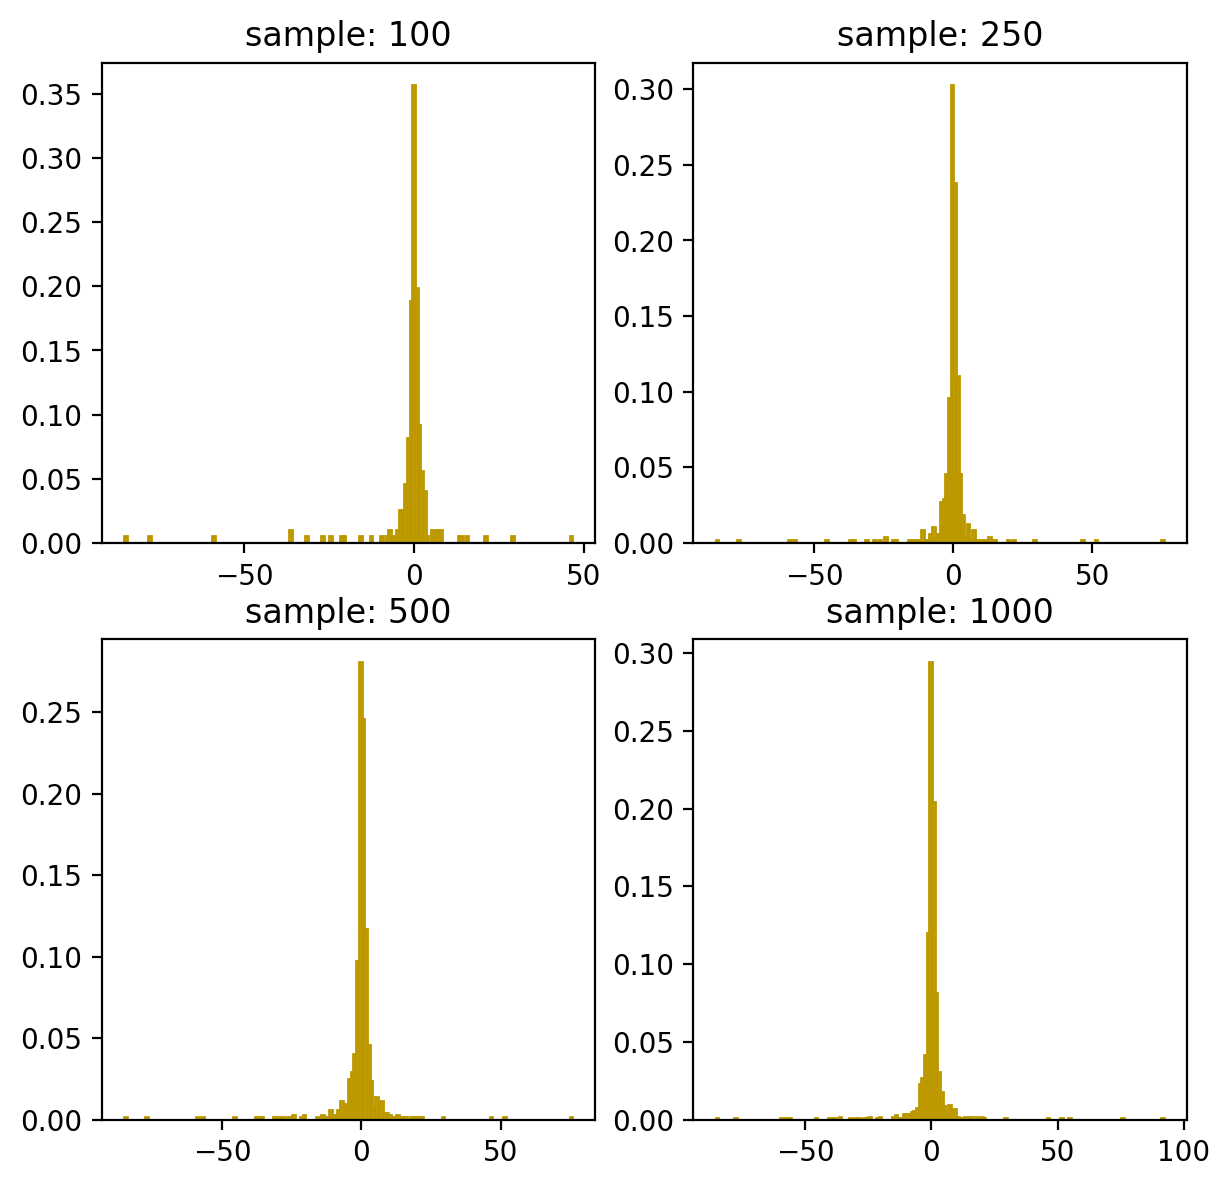

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

ax1=axes[0][0]
ax1.hist(cauchy_250,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('sample: 100')

ax2=axes[0][1]
ax2.hist(cauchy_500,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('sample: 250')

ax3=axes[1][0]
ax3.hist(cauchy_750,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax3.set_title('sample: 500')

ax4=axes[1][1]
ax4.hist(cauchy_1000,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax4.set_title('sample: 1000')

plt.show()

In [33]:
print("Median")
print(f'cauchy 250 samples: {np.median(cauchy_250)}\tcauchy 1000 samples: {np.median(cauchy_1000)}')
print("Variance")
print(f'cauchy 250 samples: {np.var(cauchy_250)}\tcauchy 1000 samples: {np.var(cauchy_1000)}')

Median
cauchy 250 samples: -0.09619496123376992	cauchy 1000 samples: -0.0016956292727746752
Variance
cauchy 250 samples: 110.9155068968102	cauchy 1000 samples: 71.38449516637478


# TASK 4

In [34]:
model_multi=stan_utility.compile_model('multi_normal.stan')

Using cached StanModel


In [35]:
data = dict(mu=[1, 0], sigma=[[1, 0.5],[0.5, 1]], eta=2)
sampling_multi = model_multi.sampling(data=data,seed=56862385,algorithm="Fixed_param",iter=1000,warmup=0,chains=1)

In [36]:
params=sampling_multi.extract()
y_sim=params['result'].T
corrMatrix=params['correl_matrix']

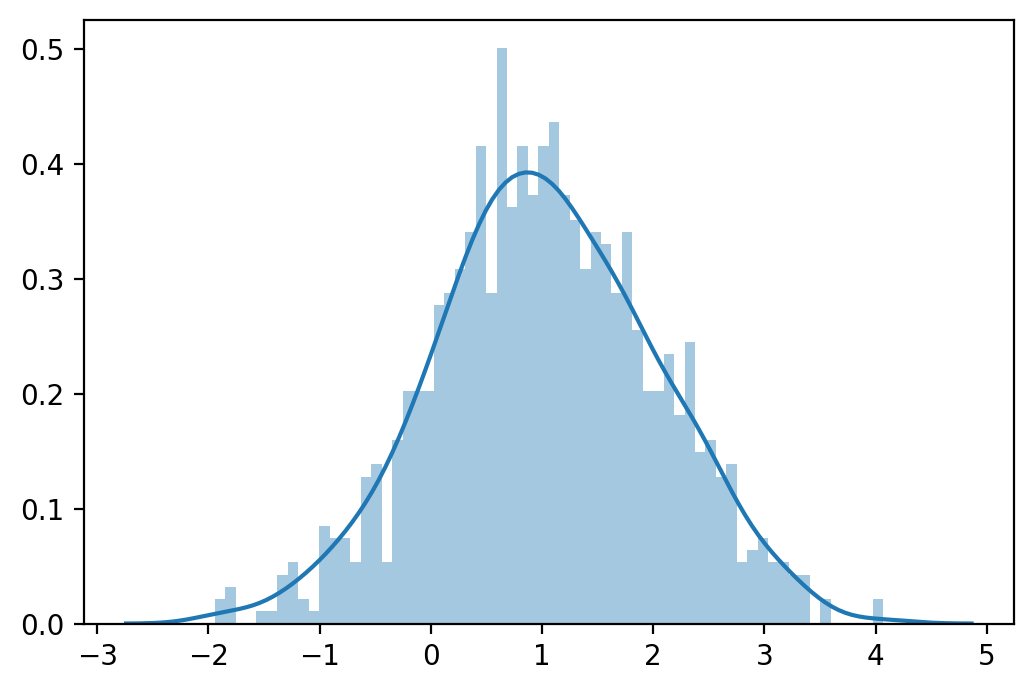

In [37]:
sns.distplot(y_sim[0].flatten(), hist=True, kde=True, bins=64)

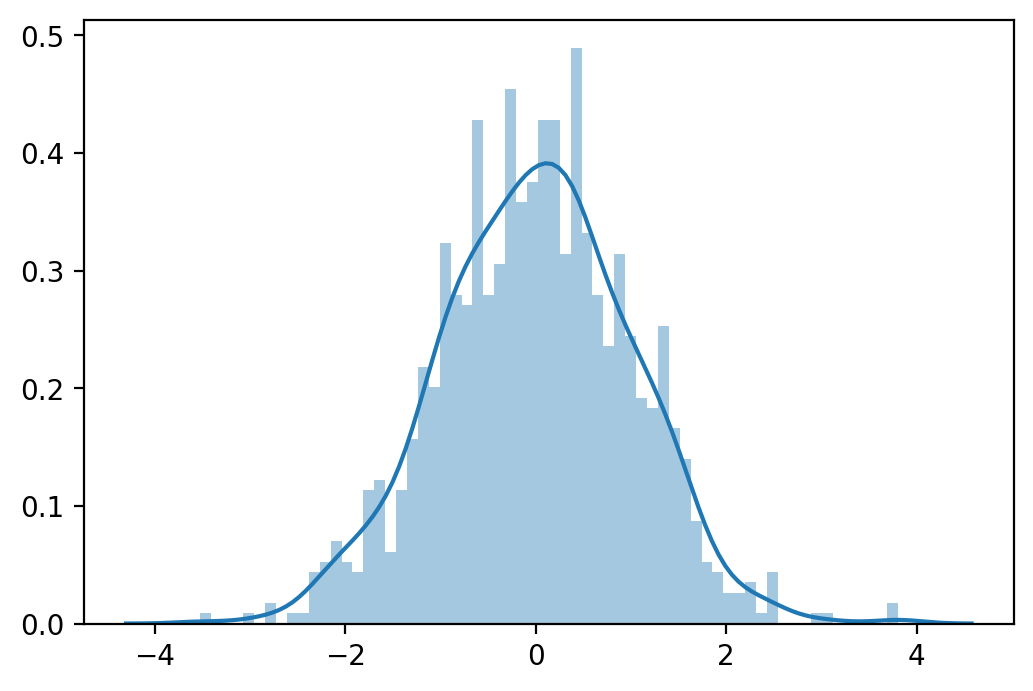

In [38]:
sns.distplot(y_sim[1].flatten(), hist=True, kde=True, bins=64)

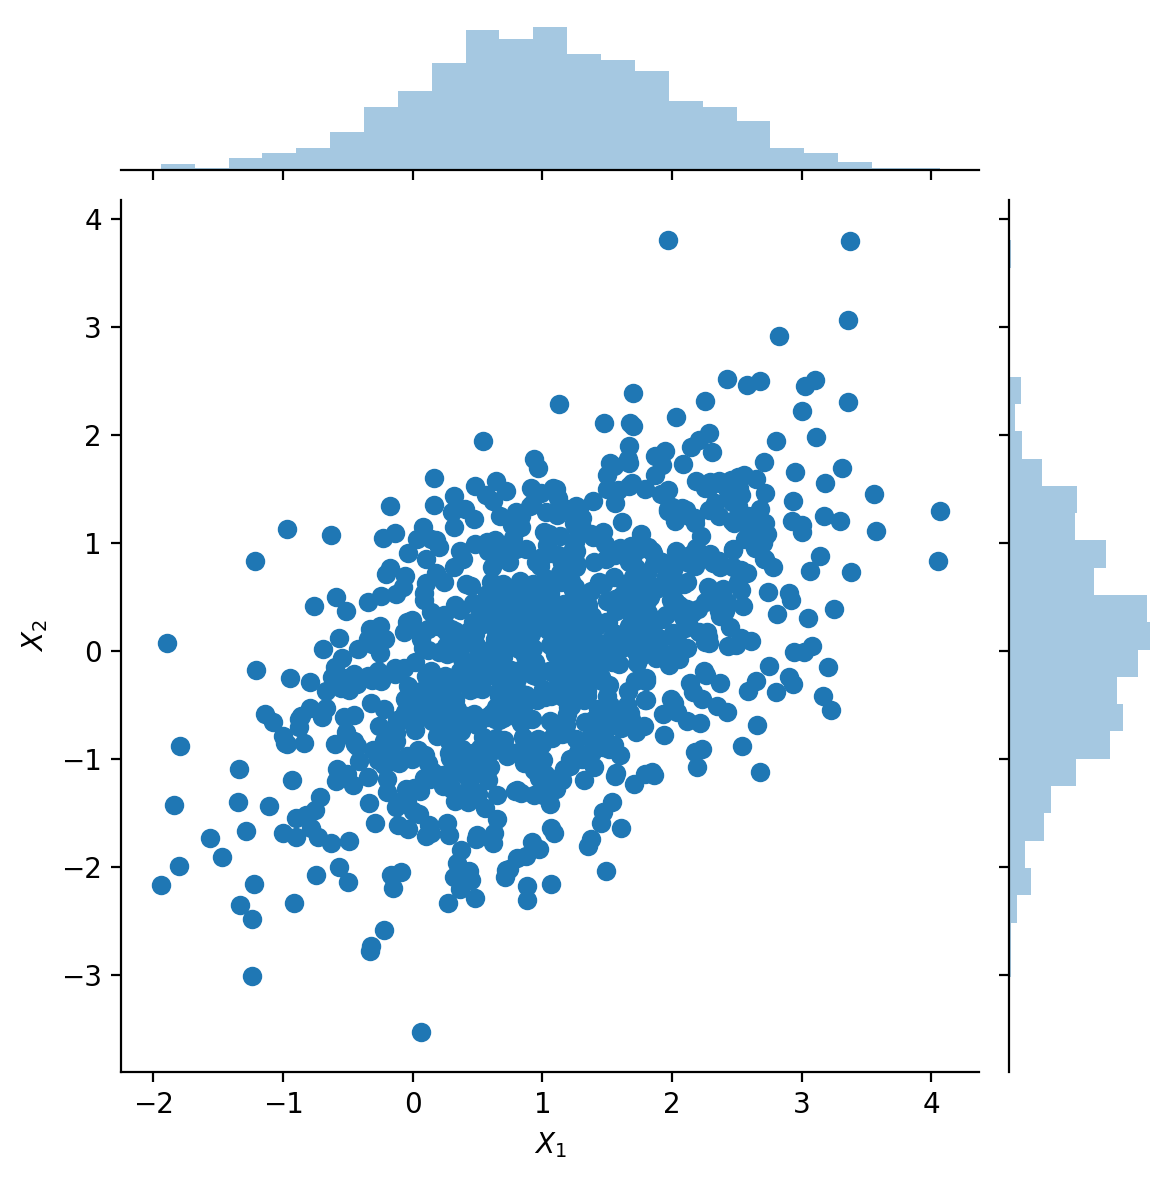

In [39]:
x1=pd.Series(y_sim[0], name="$X_1$")
x2=pd.Series(y_sim[1], name="$X_2$")

g = sns.jointplot(x1, x2)

In [40]:
model_multi_N = stan_utility.compile_model('multi_normal_N.stan')

Using cached StanModel


In [41]:
mu = [0,0,0,0]
sig = [(1, .7, .7, .7), (.7, 1, .7,.7), (.7, .7, 1,.7), (.7,.7,.7,1)]

sampling_multi_N=model_multi_N.sampling(data={'N': len(mu),
                                                                         'mu': mu,
                                                                         'sig': sig},
                                                                         iter=1000,
                                                                         seed=56862385)

In [42]:
param = sampling_multi_N.extract()
result = param['y']
result = result.T

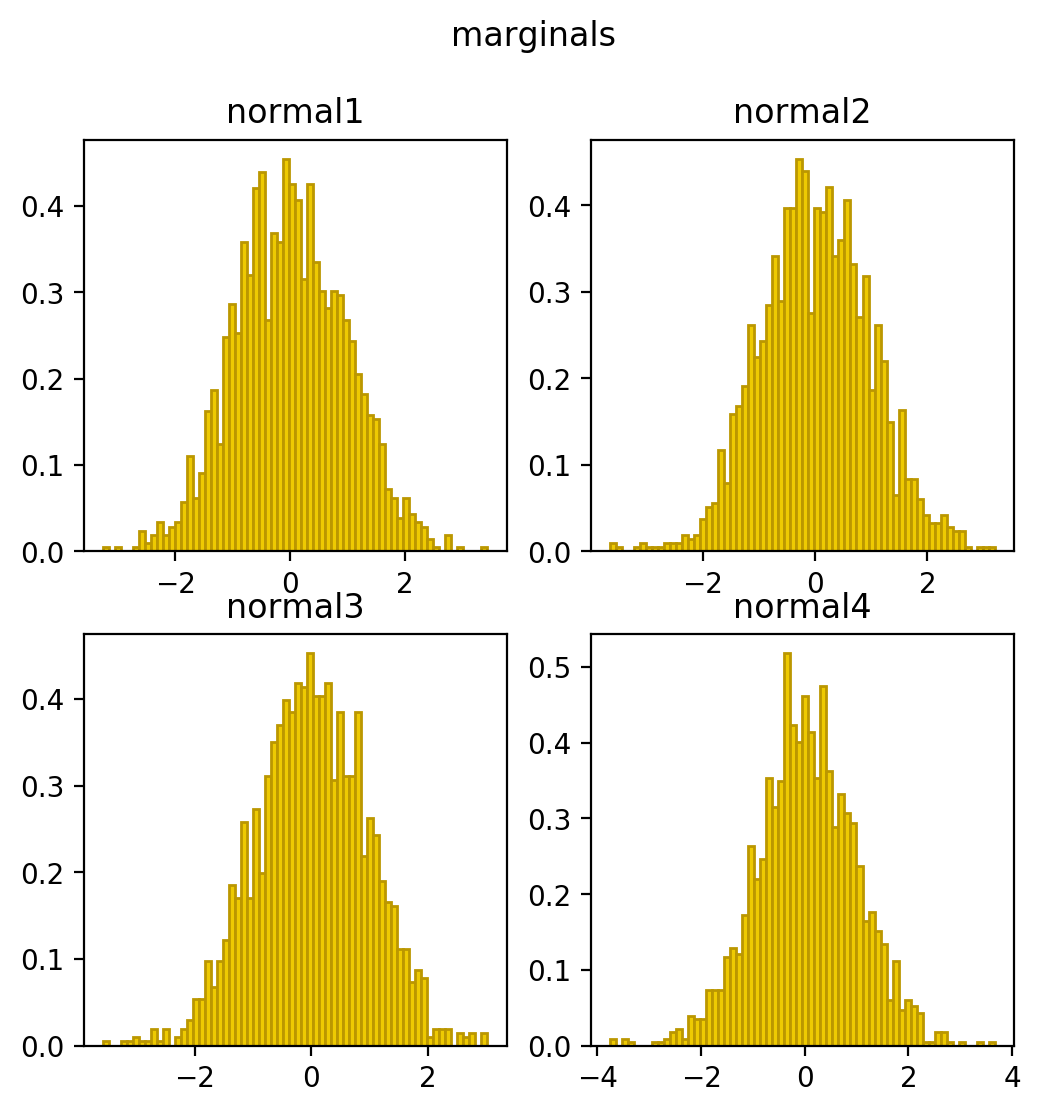

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

fig.suptitle('marginals')

ax1=axes[0][0]
ax1.hist(result[0],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal3')

ax2=axes[1][1]
ax2.hist(result[3],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal4')

plt.show()